In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
import pprint
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("flats_result_set1.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5501 entries, 0 to 5500
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  5501 non-null   int64  
 1   rooms                  5501 non-null   int64  
 2   area                   5501 non-null   float64
 3   market                 5501 non-null   object 
 4   building_type          5501 non-null   object 
 5   building_material      5501 non-null   object 
 6   year_built             5501 non-null   float64
 7   heating                5501 non-null   object 
 8   kitchen_type           5501 non-null   object 
 9   property_condition     5501 non-null   float64
 10  form_of_ownership      5501 non-null   float64
 11  district_result        5501 non-null   object 
 12  distance_from_center   5501 non-null   float64
 13  floor_of_flat          5501 non-null   int64  
 14  balconies              5501 non-null   object 
 15  park

## Analysis and preparation of data for the model

### Numeric columns

#### Removing outliers using the z-score method

In [4]:
df_num = df.select_dtypes(include=np.number)
df = df[~df_num[(np.abs(stats.zscore(df_num)) > 3)].any(axis=1)]

#### Creating histograms for numerical columns to check whether the distribution is not skewed

In [5]:
numeric_columns = df_num.drop(["price"], axis=1).columns 

Column: rooms
Unique values: 5


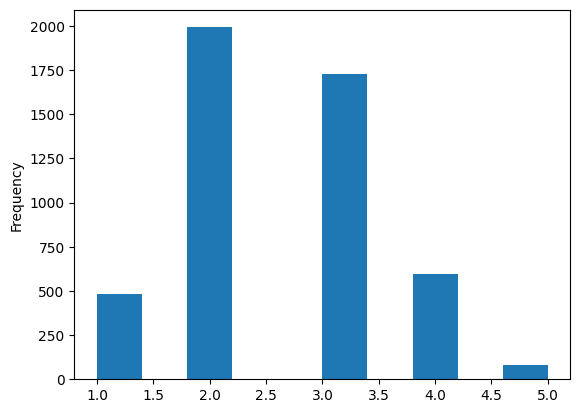

Column: area
Unique values: 1955


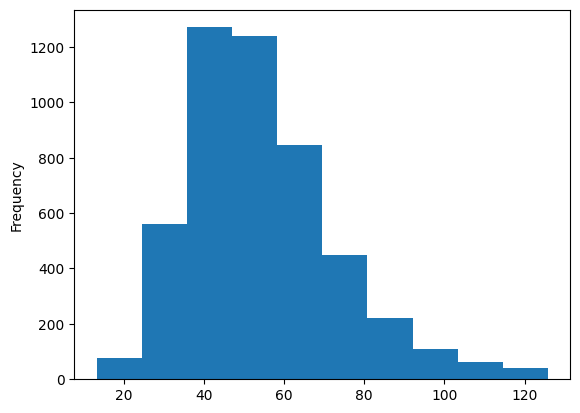

Column: year_built
Unique values: 114


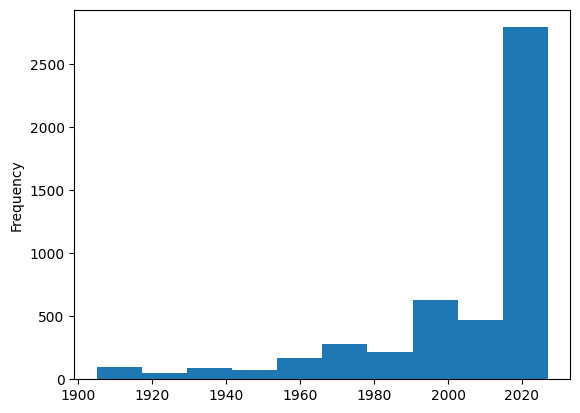

Column: property_condition
Unique values: 11


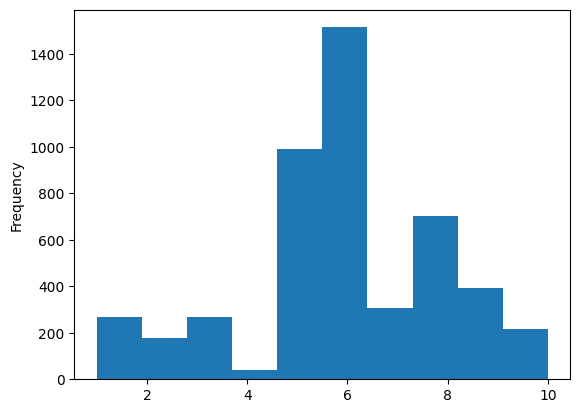

Column: form_of_ownership
Unique values: 3


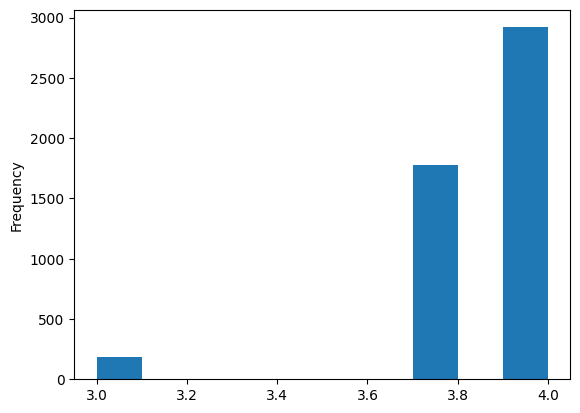

Column: distance_from_center
Unique values: 16


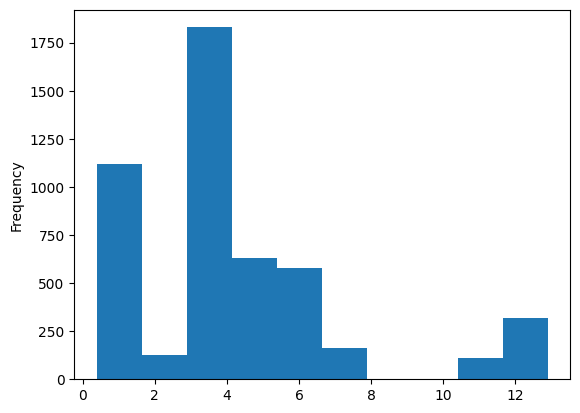

Column: floor_of_flat
Unique values: 11


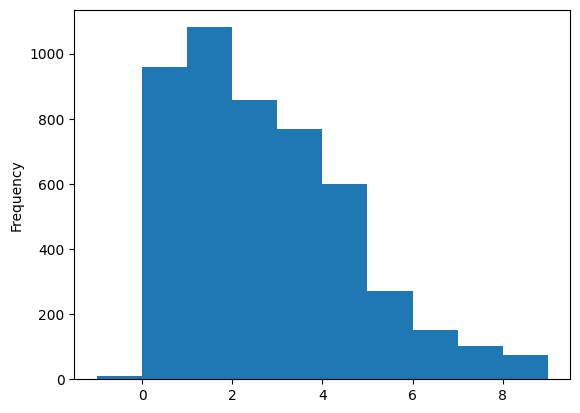

Column: rooms_to_area_ratio
Unique values: 1952


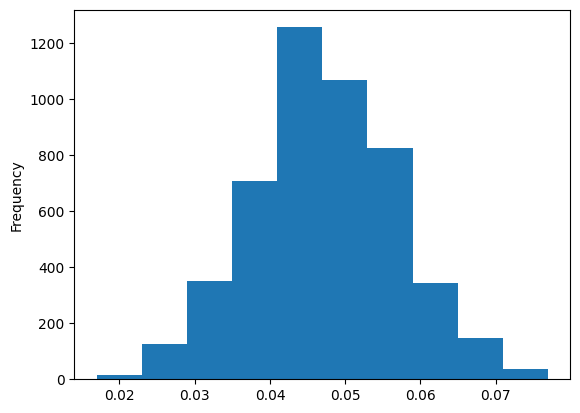

In [6]:
for column in numeric_columns:
    print(f'Column: {column}')
    print(f'Unique values: {len(df[column].unique())}')
    df[column].plot.hist()
    plt.show()

Column ""year_built" has a skewed distribution, so for linear models this column will be logarithmized.

## Defining the functions and classes needed to create models and represent results

### Logarithmizing columns where the data distribution is skewed

In [7]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__( self): 
        pass
    
    def fit( self, X, y= None ): 
        return self

    def transform(self, X, y = None ):
        X = pd.DataFrame(X)
        for col in X:
            X[col] = X[col].apply(lambda x: np.log(x))
        return X 

### Returning metrics

In [8]:
def get_metrics(y_t, y_p):
    MAE =  mean_absolute_error(y_t, y_p),
    MSE = mean_squared_error(y_t, y_p),
    RMSE = np.sqrt(mean_squared_error(y_t, y_p)),
    MAPE= mean_absolute_percentage_error(y_t, y_p)*100,
    R2 = r2_score(y_t, y_p)
                       
    return MAE, MSE, RMSE, MAPE, R2

In [9]:
def get_metrics_2(MAE, MSE, RMSE, MAPE, R2, get_index):
    df_m = pd.DataFrame({"MAE": MAE, 
                         "MSE": MSE,
                         "RMSE": RMSE,
                         "MAPE": MAPE,
                         "R2": R2},  index = [get_index]
                       )
    return df_m

## Division of the data set
Categorical variables were converted to numerical. The data will be divided into training and test sets.

In [10]:
X = pd.get_dummies(df.drop(["price"], axis=1))
y= df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Models

### Linear regression
For linear models (Linear regression, Logistic regression, ElasticNet), numerical columns should be scaled. Additionally, the "year_built" column will be logarithmized. The above data was preprocessed in the pipeline and then passed to the model.

In [11]:
num_columns_1 = [ "year_built"]
num_transformer_1 = Pipeline(steps=[
    ("log_transform", LogTransformer()),
    ("scaling", StandardScaler())
])

num_columns_2 = ["property_condition", "rooms_to_area_ratio", "rooms", "area", "form_of_ownership", "distance_from_center", "floor_of_flat"]
num_transformer_2 = Pipeline(steps=[
    ("scaling", StandardScaler())   
])
transformer = ColumnTransformer(transformers=[
    ("num1", num_transformer_1, num_columns_1),
    ("num2", num_transformer_2, num_columns_2)
], remainder="passthrough", force_int_remainder_cols=False)

In [12]:
pipeline_LinearRegression = Pipeline(steps=[
    ("preprocessor", transformer),
    ("model", LinearRegression())    
])
pipeline_LinearRegression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num1',
                                                  Pipeline(steps=[('log_transform',
                                                                   LogTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['year_built']),
                                                 ('num2',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['property_condition',
                                                   'rooms_to_area_ratio',
                                                   'rooms', 'area',
                                                   'form_of_ownership',
                                                   'distance_from_center',
                                                   'floor_of_flat'])])),
                ('model', LinearRegression())])

#### Linear regression model results:

In [13]:
y_pred = pipeline_LinearRegression.predict(X_test)
lnr_mae, lnr_mse, lnr_rmse, lnr_mape, lnr_rs = get_metrics(y_test, y_pred)
df_lnr = get_metrics_2(lnr_mae, lnr_mse, lnr_rmse, lnr_mape, lnr_rs, "model_lnr")
df_lnr

,MAE,MSE,RMSE,MAPE,R2
model_lnr,109866.029193,2.580998e+10,160654.859485,12.716871,0.758591


### Logistic regresion

In [14]:
pipeline_LogisticRegression = Pipeline(steps=[
    ("preprocessor", transformer),
    ("model", LogisticRegression())    
])
pipeline_LogisticRegression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num1',
                                                  Pipeline(steps=[('log_transform',
                                                                   LogTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['year_built']),
                                                 ('num2',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['property_condition',
                                                   'rooms_to_area_ratio',
                                                   'rooms', 'area',
                                                   'form_of_ownership',
                                                   'distance_from_center',
                                                   'floor_of_flat'])])),
                ('model', LogisticRegression())])

#### Logistic regresion model results:

In [15]:
y_pred = pipeline_LogisticRegression.predict(X_test)
logr_mae, logr_mse, logr_rmse, logr_mape, logr_rs = get_metrics(y_test, y_pred)
df_logr = get_metrics_2(logr_mae, logr_mse, logr_rmse, logr_mape, logr_rs, "model_logr")
df_logr

,MAE,MSE,RMSE,MAPE,R2
model_logr,147095.062112,4.984512e+10,223260.208381,16.651172,0.533782


### ElasticNet
Using Grid Search, we will test which parameters yield the best results for the Elastic Net model.
We will not test other regression models: Lasso and Ridge, because Elastic Net Regression combines L1 (Lasso) and L2 (Ridge) penalties.

In [16]:
pipeline_ElasticNet = Pipeline(steps=[
    ("preprocessor", transformer),
    ("model", ElasticNet())   
])
pipeline_ElasticNet.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num1',
                                                  Pipeline(steps=[('log_transform',
                                                                   LogTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['year_built']),
                                                 ('num2',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['property_condition',
                                                   'rooms_to_area_ratio',
                                                   'rooms', 'area',
                                                   'form_of_ownership',
                                                   'distance_from_center',
                                                   'floor_of_flat'])])),
                ('model', ElasticNet())])

In [17]:
param_grid = dict(preprocessor__num1__scaling=[None, MinMaxScaler(), StandardScaler()],
                  preprocessor__num2__scaling=[None, MinMaxScaler(), StandardScaler()],
                  preprocessor__num1__log_transform=[None, LogTransformer()], 
                  model__alpha=[0.1, 1, 10, 100],
                  model__l1_ratio=[0.1, 0.2, 0.5, 0.8, 1]
                 )

grid_search = GridSearchCV(pipeline_ElasticNet, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('num1',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          LogTransformer()),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         ['year_built']),
                                                                        ('num2',
                                                                         Pipeline(steps=[('scaling',
                                                                                          StandardScaler())]),
                                                                         ['property_condition',
                                                                          'rooms_to_area_ratio...
                                                                          'form_of_ownership',
                                                                          'distance_from_center',
                                                                          'floor_of_flat'])])),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': [0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.2, 0.5, 0.8, 1],
                         'preprocessor__num1__log_transform': [None,
                                                               LogTransformer()],
                         'preprocessor__num1__scaling': [None, MinMaxScaler(),
                                                         StandardScaler()],
                         'preprocessor__num2__scaling': [None, MinMaxScaler(),
                                                         StandardScaler()]})

#### Parameters of the Best ElasticNet model:

In [18]:
pprint.pprint(grid_search.best_params_)

{'model__alpha': 100,
 'model__l1_ratio': 1,
 'preprocessor__num1__log_transform': LogTransformer(),
 'preprocessor__num1__scaling': None,
 'preprocessor__num2__scaling': StandardScaler()}


#### ElasticNet model results:

In [19]:
y_pred = grid_search.best_estimator_.predict(X_test)
en_mae, en_mse, en_rmse, en_mape, en_rs = get_metrics(y_test, y_pred)
df_en = get_metrics_2(en_mae, en_mse, en_rmse, en_mape, en_rs, "model_en")
df_en

,MAE,MSE,RMSE,MAPE,R2
model_en,109478.603514,2.574798e+10,160461.7693,12.649858,0.759171


### Decision Tree Regressor
We'll be using raw data for decision trees.

Using Grid Search, we'll test which parameters yield the best results from the Decision Tree Regressor model.

In [20]:
model = DecisionTreeRegressor()
param_grid = {"min_samples_leaf": [1, 5, 10, 15, 20, 25, 30, 40, 50],
             "max_depth": [4, 5, 6, 7, None],}

optimizer = GridSearchCV(model,
                         param_grid,
                         cv=10,
                         scoring="r2",
                         n_jobs=-1)

optimizer.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, None],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 25, 30, 40,
                                              50]},
             scoring='r2')

#### Parameters of the Decision Tree Regressor model:

In [21]:
optimizer.best_params_

{'max_depth': None, 'min_samples_leaf': 5}

#### Decision Tree Regressor model results:

In [22]:
best_model_dtr = optimizer.best_estimator_
y_pred = best_model_dtr.predict(X_test)
dtr_mae, dtr_mse, dtr_rmse, dtr_mape, dtr_rs = get_metrics(y_test, y_pred)
df_dtr = get_metrics_2(dtr_mae, dtr_mse, dtr_rmse, dtr_mape, dtr_rs, "model_dtr")
df_dtr

,MAE,MSE,RMSE,MAPE,R2
model_dtr,102300.910379,2.779845e+10,166728.680153,11.196609,0.739992


### Random Forest Regressor
Using Grid Search, we'll test which parameters yield the best results from the Random Forest Regressor model.

In [23]:
model = RandomForestRegressor(random_state=42)
param_grid = {"n_estimators": [100, 200, 300],
              "min_samples_leaf": [1, 5, 10, 15, 20, 25, 30, 40, 50],
             "max_depth": [4, 5, 6, 7, None],}

optimizer = GridSearchCV(model,
                         param_grid,
                         cv=10,
                         scoring="r2",
                         n_jobs=-1)

optimizer.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, None],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 25, 30, 40, 50],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

#### Parameters of the Random Forest Regressor model:

In [24]:
optimizer.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}

#### Random Forest Regressor model results:

In [25]:
best_model_rfr = optimizer.best_estimator_
y_pred = best_model_rfr.predict(X_test)
rfr_mae, rfr_mse, rfr_rmse, rfr_mape, rfr_rs = get_metrics(y_test, y_pred)
df_rfr = get_metrics_2(rfr_mae, rfr_mse, rfr_rmse, rfr_mape, rfr_rs, "model_rfr")
df_rfr

,MAE,MSE,RMSE,MAPE,R2
model_rfr,78685.858752,1.885110e+10,137299.310401,8.617461,0.823679


## Conclusion

### Summary of metrics from all models:

In [26]:
df_metrics = pd.concat([df_lnr, df_logr, df_en, df_dtr, df_rfr])
df_metrics

,MAE,MSE,RMSE,MAPE,R2
model_lnr,109866.029193,2.580998e+10,160654.859485,12.716871,0.758591
model_logr,147095.062112,4.984512e+10,223260.208381,16.651172,0.533782
model_en,109478.603514,2.574798e+10,160461.769300,12.649858,0.759171
model_dtr,102300.910379,2.779845e+10,166728.680153,11.196609,0.739992
model_rfr,78685.858752,1.885110e+10,137299.310401,8.617461,0.823679


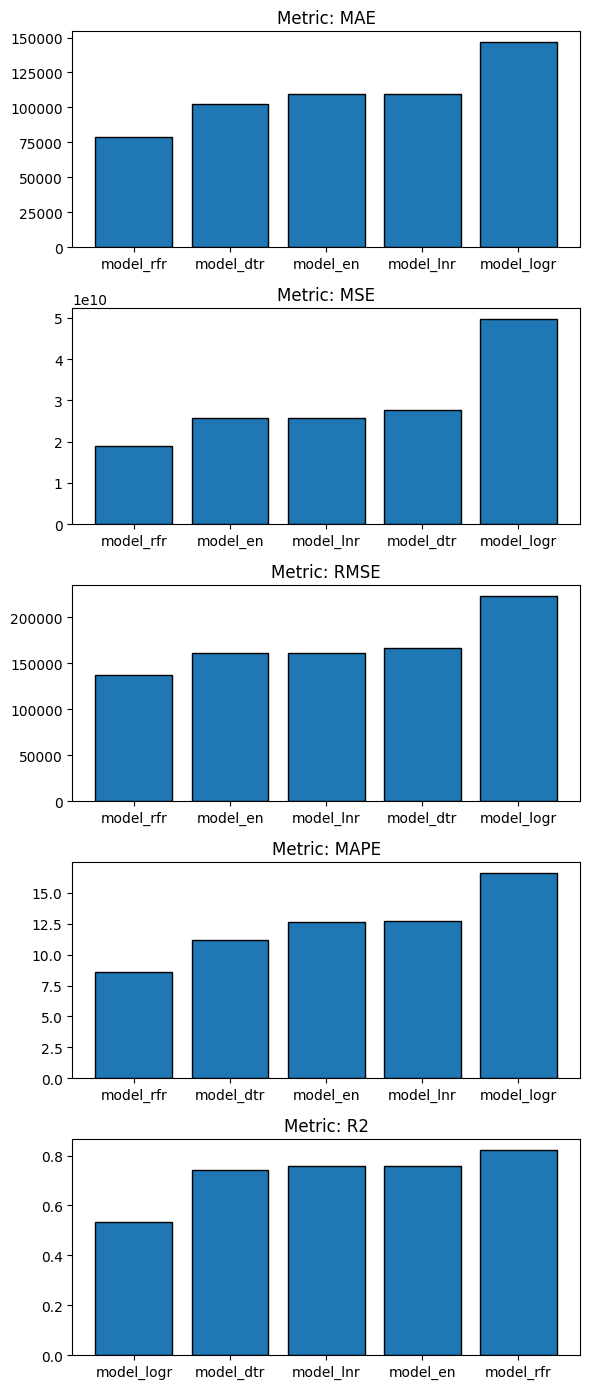

In [27]:
fig, axs = plt.subplots(nrows = 5, ncols = 1, figsize = (6, 14))

for i in range(len(df_metrics.columns)):
    axs[i].bar(df_metrics[df_metrics.columns[i]].sort_values().index, df_metrics[df_metrics.columns[i]].sort_values(), edgecolor = 'black')
    axs[i].set_title(f"Metric: {df_metrics.columns[i]}")

plt.tight_layout()
plt.show()

When selecting the best model, it is important to analyze the values of the individual model metrics. For the first four metrics: MAE (mean absolute error), MSE (mean squared error), RMSE (root mean squared error), and MAPE (mean absolute percentage error), the model is good when these metrics are as low as possible. In turn, for R2 (coefficient of determination), the model is good when this coefficient is close to zero.

As can be seen in the graphs above, the Random Forest Regressor model demonstrates the best metrics.

### Features with the greatest impact on the model

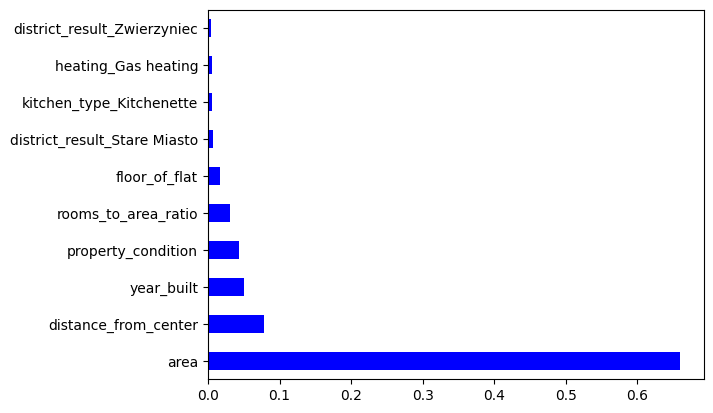

In [28]:
feat_importances = pd.Series(best_model_rfr.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='b');

The apartment's square footage has a dominant influence on price. Three other important factors are: distance from the city center, year built and  property condition.

### Test on three new, randomly selected apartments

To verify the model's validity, the model will be tested on three new, randomly selected apartments. Below are screenshots of the listings for these apartments.

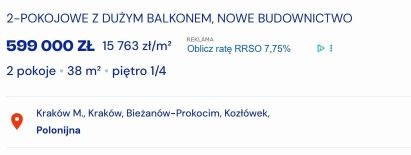

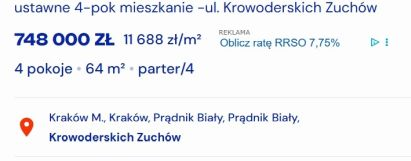

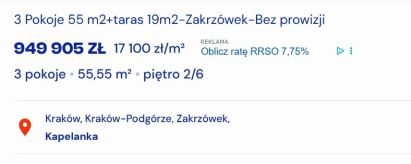

The data of three, new apartments have been entered into the Data frame.

In [29]:
df_new_flat = pd.DataFrame({
    "price": [599000, 748000, 949905],
    "rooms": [2, 4, 3],
    "area": [38, 69, 55.55],
    "year_built": [2017, 1971, 2025],
    "property_condition": [7, 1, 5],
    "form_of_ownership": [4, 2, 4],
    "distance_from_center": [7.5, 3.6, 3.6],
    "floor_of_flat": [1, 0, 2],
    "rooms_to_area_ratio": [0.052632, 0.057971, 0.054005],
    "market_Primary": [False, False, True],
    "market_Secondary": [True, True, False],
    "building_type_Apartment building": [False, True, True],
    "building_type_Detached house": [False, False, False],
    "building_type_Multi-family building": [False, False, False],
    "building_type_New construction": [True, False, False],
    "building_type_Other/ No data": [False, False, False],
    "building_type_Tenement": [False, False, False],
    "building_material_Brick": [False, False, True],
    "building_material_Concrete, reinforced concrete": [False, False, False],
    "building_material_H-frame": [False, False, False],
    "building_material_Large slab": [False, True, False],
    "building_material_Mixed construction, other": [True, False, False],
    "building_material_No data": [False, False, False],
    "heating_Central city heating": [True, True, True],
    "heating_Central heating": [False, False, False],
    "heating_Electric heating": [False, False, False],
    "heating_Gas heating": [False, False, False],
    "heating_Heat pump": [False, False, False],
    "heating_Other/ no data": [False, False, False],
    "heating_Own/ local central heating": [False, False, False],
    "kitchen_type_Bright kitchen": [False, True, False],
    "kitchen_type_Dark/ semi-open kitchen": [False, False, False],
    "kitchen_type_Kitchenette": [True, False, True],
    "kitchen_type_Other/ no data": [False, False, False],
    "kitchen_type_Separate kitchen": [False, False, False],
    "district_result_Bieńczyce": [False, False, False],
    "district_result_Bieżanów-Prokocim": [True, False, False],
    "district_result_Bronowice": [False, False, False],
    "district_result_Czyżyny": [False, False, False],
    "district_result_Dębniki": [False, False, False],
    "district_result_Grzegórzki": [False, False, False],
    "district_result_Krowodrza": [False, False, False],
    "district_result_Mistrzejowice": [False, False, False],
    "district_result_Nowa Huta": [False, False, False],
    "district_result_Podgórze": [False, False, True],
    "district_result_Podgórze Duchackie": [False, False, False],
    "district_result_Prądnik Biały": [False, True, False],
    "district_result_Prądnik Czerwony": [False, False, False],
    "district_result_Stare Miasto": [False, False, False],
    "district_result_Swoszowice": [False, False, False],
    "district_result_Wzgórza Krzesławickie": [False, False, False],
    "district_result_Zwierzyniec": [False, False, False],
    "district_result_Łagiewniki-Borek Fałęcki": [False, False, False],
    "balconies_No": [False, False, False],
    "balconies_No_data": [False, False, False],
    "balconies_Yes": [True, True, True],
    "parking_No_data": [True, False, False],
    "parking_Yes": [False, True, True],
    "basement_storage_unit_No_data": [True, False, True],
    "basement_storage_unit_Yes": [False, True, False],
    "lift_No_data": [False, True, False],
    "lift_Yes": [True, False, True],
    "smart home_No_data": [True, True, True],
    "smart home_Yes": [False, False, False],
    "air conditioning_No_data": [True, True, True],
    "air conditioning_Yes": [False, False, False]
})

In [30]:
df_new_flat

,price,rooms,area,year_built,property_condition,form_of_ownership,distance_from_center,floor_of_flat,rooms_to_area_ratio,market_Primary,...,parking_No_data,parking_Yes,basement_storage_unit_No_data,basement_storage_unit_Yes,lift_No_data,lift_Yes,smart home_No_data,smart home_Yes,air conditioning_No_data,air conditioning_Yes
0,599000,2,38.00,2017,7,4,7.5,1,0.052632,False,...,True,False,True,False,False,True,True,False,True,False
1,748000,4,69.00,1971,1,2,3.6,0,0.057971,False,...,False,True,False,True,True,False,True,False,True,False
2,949905,3,55.55,2025,5,4,3.6,2,0.054005,True,...,False,True,True,False,False,True,True,False,True,False


Let's calculate the predictions for the Random Forest Regressor model

In [31]:
X_new_flat = df_new_flat.drop("price", axis = 1)

In [32]:
y_pred = best_model_rfr.predict(X_new_flat)

We create a data frame with prediction values for apartments: 

In [33]:
df_new_flat_pred = pd.DataFrame({"estimated_price": y_pred})
df_new_flat_pred

,estimated_price
0,589105.676667
1,977450.620000
2,983998.210000


We combine data frames with apartment features with data frames with predictions:

In [34]:
df_new_flats_result = pd.concat([df_new_flat, df_new_flat_pred], axis=1)
df_new_flats_result

,price,rooms,area,year_built,property_condition,form_of_ownership,distance_from_center,floor_of_flat,rooms_to_area_ratio,market_Primary,...,parking_Yes,basement_storage_unit_No_data,basement_storage_unit_Yes,lift_No_data,lift_Yes,smart home_No_data,smart home_Yes,air conditioning_No_data,air conditioning_Yes,estimated_price
0,599000,2,38.00,2017,7,4,7.5,1,0.052632,False,...,False,True,False,False,True,True,False,True,False,589105.676667
1,748000,4,69.00,1971,1,2,3.6,0,0.057971,False,...,True,False,True,True,False,True,False,True,False,977450.620000
2,949905,3,55.55,2025,5,4,3.6,2,0.054005,True,...,True,True,False,False,True,True,False,True,False,983998.210000


To analyze the results, we create two new columns: the difference between the current price and the estimated price and the price per square meter:

In [35]:
df_new_flats_result["price_difference"] = df_new_flats_result.price - df_new_flats_result.estimated_price

In [36]:
df_new_flats_result["price_per_square_meter"] = round(df_new_flats_result.price / df_new_flats_result.area)

In [37]:
df_new_flats_result

,price,rooms,area,year_built,property_condition,form_of_ownership,distance_from_center,floor_of_flat,rooms_to_area_ratio,market_Primary,...,basement_storage_unit_Yes,lift_No_data,lift_Yes,smart home_No_data,smart home_Yes,air conditioning_No_data,air conditioning_Yes,estimated_price,price_difference,price_per_square_meter
0,599000,2,38.00,2017,7,4,7.5,1,0.052632,False,...,False,False,True,True,False,True,False,589105.676667,9894.323333,15763.0
1,748000,4,69.00,1971,1,2,3.6,0,0.057971,False,...,True,True,False,True,False,True,False,977450.620000,-229450.620000,10841.0
2,949905,3,55.55,2025,5,4,3.6,2,0.054005,True,...,False,False,True,True,False,True,False,983998.210000,-34093.210000,17100.0


We display the features with the greatest impact on the model and newly created columns:

In [38]:
df_new_flats_result[["area", 
                     "year_built", 
                     "distance_from_center", 
                     "property_condition", 
                     "price", 
                     "estimated_price", 
                     "price_difference", 
                     "price_per_square_meter"]]

,area,year_built,distance_from_center,property_condition,price,estimated_price,price_difference,price_per_square_meter
0,38.00,2017,7.5,7,599000,589105.676667,9894.323333,15763.0
1,69.00,1971,3.6,1,748000,977450.620000,-229450.620000,10841.0
2,55.55,2025,3.6,5,949905,983998.210000,-34093.210000,17100.0


The projected price of the first and third apartments does not differ significantly from the current price (the price differences are PLN 10,000 and PLN 34,000 for the first and third apartments).

The situation is different in the case of the second apartment. Here, the price difference is quite significant (PLN 223,000), but as you can see, the price per square meter is very low, just under PLN 11,000 per square meter, compared to the average asking price for an apartment in Krakow in May 2015, which was around PLN 16,000 per square meter. Although the property's condition has the lowest rating in the "property_condition" column (1), the apartment's area is large, less than 70 square meters, so the model estimated the apartment significantly higher than its actual price. It's worth noting that the condition of the property is a subjective assessment by the listing agent, so it's possible that apartments with the same condition may differ dramatically.

The price per square meter for larger apartments is usually lower than for smaller apartments. Therefore, for larger apartments, where the price per square meter deviates significantly from the average, larger errors may occur.

### Summary

Below is a graph showing the relationship between the predicted and actual price and the ideal prediction (dashed line).

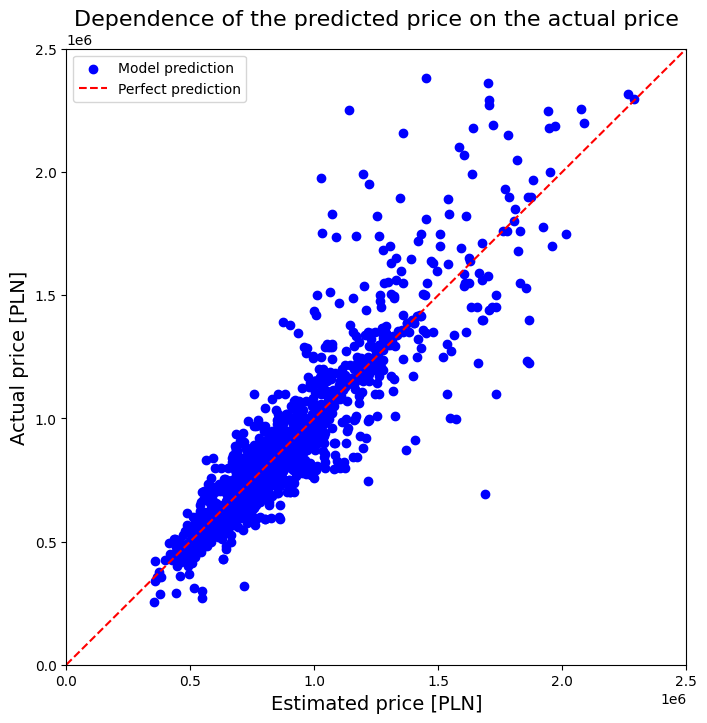

In [39]:
y_pred = best_model_rfr.predict(X_test)
plt.figure(figsize=(8, 8))

plt.scatter(y_pred, y_test, label='Model prediction', color = "b")
plt.plot([0, 2.5e6], [0, 2.5e6], 'r--', label='Perfect prediction')

plt.title("Dependence of the predicted price on the actual price", fontsize=16)
plt.xlabel("Estimated price [PLN]", fontsize=14)
plt.ylabel("Actual price [PLN]", fontsize=14)
plt.xlim([0, 2.5e6])
plt.ylim([0, 2.5e6])

plt.legend();

We can see that the model performs best for cheaper and mid-priced properties, which are the most common. For more expensive properties, the model doesn't perform as well. This is likely due to the fact that property prices are influenced by many factors, not necessarily captured by the features used to build the model. This is particularly true for the most expensive apartments, where the exclusivity of the apartment isn't directly related to its square footage or location, but rather to its expensive finishing, amenities such as a gym or swimming pool.

On the other hand, an apartment with a very large square footage isn't necessarily expensive if, for example, the property is located in a dilapidated old building, in a poor and dangerous neighborhood, and requires a costly, comprehensive renovation.
As we've seen, the model is most influenced by square footage. Therefore, properties where other factors have a greater impact on the price and the price per square meter deviates significantly from the average may be subject to greater error.

Another important issue is that apartment prices are asking prices, not transaction prices. Therefore, they are not actual apartment prices, and therefore some may be overestimated or underestimated.

It should also be noted that there were many missing data and errors, which undoubtedly significantly impacted the model.

Despite the difficulties mentioned above, the model predicts apartment prices quite well. The average difference between the apartment price and the prediction is approximately PLN 79,000, which, considering the current high apartment prices and sellers' subjective assessment of apartment value, is, in my opinion, a good result.